In [1]:
import mdptoolbox
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as ss
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=ss.SparseEfficiencyWarning)

In [7]:
# params
alpha = 0.4
T = 8
state_count = (T+1) * (T+1)
epsilon = 10e-5

# game
action_count = 3
adopt = 0; override = 1; mine = 2

# mapping utils
state_mapping = {}
states = []
count = 0
for a in range(T+1):
    for h in range(T+1):
            state_mapping[(a, h)] = count
            states.append((a, h))
            count += 1

# initialize matrices
transitions = []; reward = []
for _ in range(action_count):
    transitions.append(ss.csr_matrix(np.zeros(shape=(state_count, state_count))))
    reward.append(ss.csr_matrix(np.zeros(shape=(state_count, state_count))))

In [27]:
difficulty = 1
mining_cost = difficulty / 2 

# populate matrices
for state_index in range(state_count):
    a, h = states[state_index]

    # adopt transitions
    transitions[adopt][state_index, state_mapping[0, 0]] = 1

    # override
    if a > h:
        transitions[override][state_index, state_mapping[a-h-1, 0]] = 1
        reward[override][state_index, state_mapping[a-h-1, 0]] = h + 1
    else:
        transitions[override][state_index, 0] = 1
        reward[override][state_index, 0] = -10000

    # mine transitions
    if (a < T) and (h < T):
        transitions[mine][state_index, state_mapping[a+1, h]] = alpha * difficulty
        transitions[mine][state_index, state_mapping[a, h+1]] = (1 - alpha) * difficulty 
        reward[mine][state_index, state_mapping[a+1, h]] = -1 * alpha * mining_cost
        reward[mine][state_index, state_mapping[a, h+1]] = -1 * alpha * mining_cost
#         transitions[mine][state_index, state_mapping[a, h]] = 1 - (1 - alpha) * difficulty  - alpha * difficulty
#         reward[mine][state_index, state_mapping[a, h]] = -1 * alpha * mining_cost
        
    else:
        transitions[mine][state_index, 0] = 1
        reward[mine][state_index, 0] = -10000

In [28]:
rvi = mdptoolbox.mdp.RelativeValueIteration(transitions, reward, epsilon/8)
rvi.run()
policy = rvi.policy

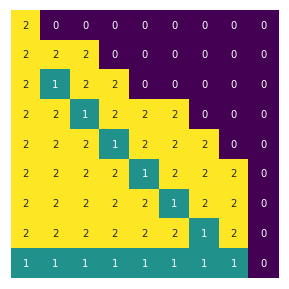

In [29]:
f, ax = plt.subplots(figsize=(6,6))
ax.imshow(np.reshape(policy, (9,9)))
ax = sns.heatmap(np.reshape(policy, (9,9)), annot=True, cmap='viridis')
cb = ax.collections[-1].colorbar   
cb.remove()
plt.xticks([])
plt.yticks([])
plt.show()